In [17]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
import tensorflow as tf
from tensorflow import keras

In [19]:
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers
from keras import applications
from keras.callbacks import History
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [20]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [21]:
sns.set_style("ticks")
sns.set_style('whitegrid')

In [22]:
########## START OF XGBOOST  #########

In [23]:
df_xgb = pd.read_csv("data/cleaned_final_data.csv")
df_xgb = df_xgb.drop_duplicates()

# REMOVE 2023 DATA
df_xgb = df_xgb[df_xgb['year'] != 2023]

# Create date time column based on Month and Year
df_xgb['date'] = pd.to_datetime(df_xgb['year'].astype(str) + '-' + df_xgb['month'].astype(str), format='%Y-%m')
df_xgb = df_xgb.set_index('date')
df_xgb.index = pd.to_datetime(df_xgb.index)
df_xgb = df_xgb.dropna( how='any', axis=0)

df_xgb['half_of_year'] = 1
df_xgb.loc[df_xgb.index.month > 6, 'half_of_year'] = 2

# Create a date
df_xgb['half_of_year_date'] = pd.to_datetime(df_xgb['year'].astype(str) + np.where(df_xgb.index.month > 6, '1231', '0630'), format='%Y%m%d')

# convert month_remaining_lease into year_remaining_lease
df_xgb['year_remaining_lease'] = np.floor(df_xgb['month_remaining_lease'] / 12)
df_xgb['year_remaining_lease'] = df_xgb['year_remaining_lease'].astype(int)

print(df_xgb.index)
df_xgb[df_xgb['half_of_year'] == 2].tail()

DatetimeIndex(['2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01', '2017-01-01', '2017-01-01',
               '2017-01-01', '2017-01-01',
               ...
               '2022-12-01', '2022-12-01', '2022-12-01', '2022-12-01',
               '2022-12-01', '2022-12-01', '2022-12-01', '2022-12-01',
               '2022-12-01', '2022-12-01'],
              dtype='datetime64[ns]', name='date', length=143140, freq=None)


,year,month,region,town,block,street_name,lease_commence_date,month_remaining_lease,flat_type,flat_model,...,nearest_mall,min_dist_mall,min_dist_town_in_km,total_population,cpi,psi,resale_price,half_of_year,half_of_year_date,year_remaining_lease
date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,2022,12,north,YISHUN,355,YISHUN RING ROAD,1988,780,EXECUTIVE,7,...,Wisteria Mall,0.912871,14.673431,1.670454,111.186,26,845000.0,2,2022-12-31,65
2022-12-01,2022,12,north,YISHUN,643,YISHUN STREET 61,1987,766,EXECUTIVE,3,...,Wisteria Mall,0.569593,14.298069,1.670454,111.186,26,782000.0,2,2022-12-31,63
2022-12-01,2022,12,north,YISHUN,643,YISHUN STREET 61,1987,766,EXECUTIVE,3,...,Wisteria Mall,0.569593,14.298069,1.670454,111.186,26,770888.0,2,2022-12-31,63
2022-12-01,2022,12,north,YISHUN,606,YISHUN STREET 61,1987,768,EXECUTIVE,7,...,Wisteria Mall,0.668656,14.313197,1.670454,111.186,26,788000.0,2,2022-12-31,64
2022-12-01,2022,12,north,YISHUN,606,YISHUN STREET 61,1987,768,EXECUTIVE,3,...,Wisteria Mall,0.668656,14.313197,1.670454,111.186,26,740000.0,2,2022-12-31,64


In [24]:
# REMOVE OUTLIERS
from scipy import stats

# Define the columns to group by
group_columns = ['half_of_year_date','town','year_remaining_lease','flat_type']

# Define the column to visualize outliers for
outlier_column = 'resale_price'

# Define a threshold for outliers (e.g., z-score > 3 or < -3)
threshold = 3

# Define a function to remove outliers for each group
def remove_outliers(group):
    z_scores = stats.zscore(group[outlier_column])
    mask = (abs(z_scores) < threshold)
    return group[mask]
print(len(df_xgb))
# Apply the function to each group
df_xgb = df_xgb.groupby(group_columns).apply(remove_outliers)
print(len(df_xgb))


143140
139789


In [25]:
# group by
df_xgb.reset_index(drop=True, inplace=True)
df_xgb_grpby = df_xgb.groupby([df_xgb.half_of_year_date, df_xgb.year, df_xgb.town,df_xgb.flat_type]).median()[['resale_price','cpi','floor_area_sqm','min_dist_town_in_km','year_remaining_lease']]


df_xgb_grpby

C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\3356024725.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_xgb_grpby = df_xgb.groupby([df_xgb.half_of_year_date, df_xgb.year, df_xgb.town,df_xgb.flat_type]).median()[['resale_price','cpi','floor_area_sqm','min_dist_town_in_km','year_remaining_lease']]


resale_price      cpi  \
half_of_year_date year town       flat_type                                 
2017-06-30        2017 ANG MO KIO 2 ROOM                234000.0   99.023   
                                  3 ROOM                310000.0   99.026   
                                  4 ROOM                460000.0   99.026   
                                  5 ROOM                675000.0   99.023   
                                  EXECUTIVE             820000.0   99.026   
...                                                          ...      ...   
2022-12-31        2022 YISHUN     3 ROOM                365000.0  110.339   
                                  4 ROOM                475000.0  109.893   
                                  5 ROOM                615000.0  109.893   
                                  EXECUTIVE             778000.0  110.339   
                                  MULTI-GENERATION      970000.0  110.116   

                                                    floor_area_sqm  \
half_of_year_date year town       flat_type                          
2017-06-30        2017 ANG MO KIO 2 ROOM                      44.0   
                                  3 ROOM                      68.0   
                                  4 ROOM                      92.0   
                                  5 ROOM                     118.0   
                                  EXECUTIVE                  149.0   
...                                                            ...   
2022-12-31        2022 YISHUN     3 ROOM                      68.0   
                                  4 ROOM                      93.0   
                                  5 ROOM                     113.0   
                                  EXECUTIVE                  146.0   
                                  MULTI-GENERATION           164.0   

                                                    min_dist_town_in_km  \
half_of_year_date year town       flat_type                               
2017-06-30        2017 ANG MO KIO 2 ROOM                       8.607327   
                                  3 ROOM                       8.573402   
                                  4 ROOM                       8.692403   
                                  5 ROOM                       8.739997   
                                  EXECUTIVE                    9.520225   
...                                                                 ...   
2022-12-31        2022 YISHUN     3 ROOM                      15.264115   
                                  4 ROOM                      14.382665   
                                  5 ROOM                      14.387993   
                                  EXECUTIVE                   14.811392   
                                  MULTI-GENERATION            13.989136   

                                                    year_remaining_lease  
half_of_year_date year town       flat_type                               
2017-06-30        2017 ANG MO KIO 2 ROOM                            61.5  
                                  3 ROOM                            61.0  
                                  4 ROOM                            62.0  
                                  5 ROOM                            78.0  
                                  EXECUTIVE                         78.0  
...                                                                  ...  
2022-12-31        2022 YISHUN     3 ROOM                            63.0  
                                  4 ROOM                            64.0  
                                  5 ROOM                            78.0  
                                  EXECUTIVE                         64.0  
                                  MULTI-GENERATION                  64.0  

[1450 rows x 5 columns]

In [26]:
cols_to_norm = [
    'month_remaining_lease', 'floor_area_sqm',
    'storey_range_low', 'storey_range_high',
    'min_dist_mrt', 'min_dist_mall', 'min_dist_town_in_km', 'total_population', 'resale_price']

scaler = MinMaxScaler()
df_xgb_grpby = pd.DataFrame(scaler.fit_transform(df_xgb_grpby), columns=df_xgb_grpby.columns, index=df_xgb_grpby.index)
min_val = scaler.data_min_
max_val = scaler.data_max_


# scaler = StandardScaler()

# df_xgb_grpby = pd.DataFrame(scaler.fit_transform(df_xgb_grpby), columns=df_xgb_grpby.columns, index=df_xgb_grpby.index)

df_xgb_grpby

resale_price       cpi  \
half_of_year_date year town       flat_type                                  
2017-06-30        2017 ANG MO KIO 2 ROOM                0.061883  0.023836   
                                  3 ROOM                0.130045  0.024077   
                                  4 ROOM                0.264574  0.024077   
                                  5 ROOM                0.457399  0.023836   
                                  EXECUTIVE             0.587444  0.024077   
...                                                          ...       ...   
2022-12-31        2022 YISHUN     3 ROOM                0.179372  0.932022   
                                  4 ROOM                0.278027  0.896228   
                                  5 ROOM                0.403587  0.896228   
                                  EXECUTIVE             0.549776  0.932022   
                                  MULTI-GENERATION      0.721973  0.914125   

                                                    floor_area_sqm  \
half_of_year_date year town       flat_type                          
2017-06-30        2017 ANG MO KIO 2 ROOM                  0.092857   
                                  3 ROOM                  0.264286   
                                  4 ROOM                  0.435714   
                                  5 ROOM                  0.621429   
                                  EXECUTIVE               0.842857   
...                                                            ...   
2022-12-31        2022 YISHUN     3 ROOM                  0.264286   
                                  4 ROOM                  0.442857   
                                  5 ROOM                  0.585714   
                                  EXECUTIVE               0.821429   
                                  MULTI-GENERATION        0.950000   

                                                    min_dist_town_in_km  \
half_of_year_date year town       flat_type                               
2017-06-30        2017 ANG MO KIO 2 ROOM                       0.428581   
                                  3 ROOM                       0.426629   
                                  4 ROOM                       0.433477   
                                  5 ROOM                       0.436216   
                                  EXECUTIVE                    0.481118   
...                                                                 ...   
2022-12-31        2022 YISHUN     3 ROOM                       0.811674   
                                  4 ROOM                       0.760948   
                                  5 ROOM                       0.761254   
                                  EXECUTIVE                    0.785621   
                                  MULTI-GENERATION             0.738300   

                                                    year_remaining_lease  
half_of_year_date year town       flat_type                               
2017-06-30        2017 ANG MO KIO 2 ROOM                        0.355769  
                                  3 ROOM                        0.346154  
                                  4 ROOM                        0.365385  
                                  5 ROOM                        0.673077  
                                  EXECUTIVE                     0.673077  
...                                                                  ...  
2022-12-31        2022 YISHUN     3 ROOM                        0.384615  
                                  4 ROOM                        0.403846  
                                  5 ROOM                        0.673077  
                                  EXECUTIVE                     0.403846  
                                  MULTI-GENERATION              0.403846  

[1450 rows x 5 columns]

In [27]:
df_xgb = df_xgb_grpby.reset_index()
df_xgb = df_xgb.set_index('half_of_year_date')
df_xgb.index = pd.to_datetime(df_xgb.index)
df_xgb.sort_index(inplace=True)

freq = df_xgb.index.value_counts()
print(freq.sort_index())
df_xgb

2017-06-30    112
2017-12-31    116
2018-06-30    119
2018-12-31    122
2019-06-30    120
2019-12-31    122
2020-06-30    120
2020-12-31    125
2021-06-30    124
2021-12-31    121
2022-06-30    124
2022-12-31    125
Name: half_of_year_date, dtype: int64


,year,town,flat_type,resale_price,cpi,floor_area_sqm,min_dist_town_in_km,year_remaining_lease
half_of_year_date,,,,,,,,
2017-06-30,2017,ANG MO KIO,2 ROOM,0.061883,0.023836,0.092857,0.428581,0.355769
2017-06-30,2017,ANG MO KIO,3 ROOM,0.130045,0.024077,0.264286,0.426629,0.346154
2017-06-30,2017,ANG MO KIO,4 ROOM,0.264574,0.024077,0.435714,0.433477,0.365385
2017-06-30,2017,ANG MO KIO,5 ROOM,0.457399,0.023836,0.621429,0.436216,0.673077
2017-06-30,2017,ANG MO KIO,EXECUTIVE,0.587444,0.024077,0.842857,0.481118,0.673077
...,...,...,...,...,...,...,...,...
2022-12-31,2022,YISHUN,3 ROOM,0.179372,0.932022,0.264286,0.811674,0.384615
2022-12-31,2022,YISHUN,4 ROOM,0.278027,0.896228,0.442857,0.760948,0.403846
2022-12-31,2022,YISHUN,5 ROOM,0.403587,0.896228,0.585714,0.761254,0.673077


In [28]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit



In [29]:
# Lag Feature
def add_lags(df_grp):
    mydf = df_grp.copy()
    target_df = mydf["resale_price"].to_frame()
    target_df.reset_index(inplace=True)
    target_df['key'] = target_df['half_of_year_date'].astype(str) + '-' + target_df['town'].astype(str) + '-'  + target_df['flat_type'].astype(str) 
    target_dict = target_df.set_index('key')['resale_price'].to_dict()
    mydf.reset_index(inplace=True)

    my_dates_6 = mydf.half_of_year_date - pd.DateOffset(months=6) 
    my_dates_12 = mydf.half_of_year_date - pd.DateOffset(months=12) 
    my_dates_18 = mydf.half_of_year_date - pd.DateOffset(months=18) 
    my_dates_24 = mydf.half_of_year_date - pd.DateOffset(months=24) 

    is_last_day = my_dates_6.dt.is_month_end
    my_dates_6.loc[~is_last_day] = my_dates_6.loc[~is_last_day] + pd.offsets.MonthEnd(1)
    is_last_day = my_dates_12.dt.is_month_end
    my_dates_12.loc[~is_last_day] = my_dates_12.loc[~is_last_day] + pd.offsets.MonthEnd(1)
    is_last_day = my_dates_18.dt.is_month_end
    my_dates_18.loc[~is_last_day] = my_dates_18.loc[~is_last_day] + pd.offsets.MonthEnd(1)
    is_last_day = my_dates_24.dt.is_month_end
    my_dates_24.loc[~is_last_day] = my_dates_24.loc[~is_last_day] + pd.offsets.MonthEnd(1)

    mydf["TEMP_previous_half_year_date"] = my_dates_6
    mydf['key'] = mydf['TEMP_previous_half_year_date'].astype(str) + '-' + mydf['town'].astype(str) + '-'  + mydf['flat_type'].astype(str) 
    mydf['lag1'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))

    mydf["TEMP_previous_half_year_date"] = my_dates_12
    mydf['key'] = mydf['TEMP_previous_half_year_date'].astype(str) + '-' + mydf['town'].astype(str) + '-'  + mydf['flat_type'].astype(str) 
    mydf['lag2'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))

    mydf["TEMP_previous_half_year_date"] = my_dates_18
    mydf['key'] = mydf['TEMP_previous_half_year_date'].astype(str) + '-' + mydf['town'].astype(str) + '-'  + mydf['flat_type'].astype(str) 
    mydf['lag3'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))

    mydf["TEMP_previous_half_year_date"] = my_dates_24
    mydf['key'] = mydf['TEMP_previous_half_year_date'].astype(str) + '-' + mydf['town'].astype(str) + '-'  + mydf['flat_type'].astype(str) 
    mydf['lag4'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))


    #drop temp keys
    mydf.drop("TEMP_previous_half_year_date", axis=1, inplace=True)
    mydf.drop("key", axis=1, inplace=True)
    mydf

    #group again and reset index
    mydf = mydf.groupby([mydf.half_of_year_date,mydf.town, mydf.flat_type]).median()[['resale_price','cpi','floor_area_sqm','min_dist_town_in_km','year_remaining_lease','lag1','lag2','lag3','lag4']]
    mydf
    return mydf


In [30]:
df_xgb_grpby = df_xgb.groupby([df_xgb.index,df_xgb.town, df_xgb.flat_type]).median()[['resale_price','cpi','floor_area_sqm','min_dist_town_in_km','year_remaining_lease']]

df_xgb_grpby.index

MultiIndex([('2017-06-30', 'ANG MO KIO',           '2 ROOM'),
            ('2017-06-30', 'ANG MO KIO',           '3 ROOM'),
            ('2017-06-30', 'ANG MO KIO',           '4 ROOM'),
            ('2017-06-30', 'ANG MO KIO',           '5 ROOM'),
            ('2017-06-30', 'ANG MO KIO',        'EXECUTIVE'),
            ('2017-06-30',      'BEDOK',           '2 ROOM'),
            ('2017-06-30',      'BEDOK',           '3 ROOM'),
            ('2017-06-30',      'BEDOK',           '4 ROOM'),
            ('2017-06-30',      'BEDOK',           '5 ROOM'),
            ('2017-06-30',      'BEDOK',        'EXECUTIVE'),
            ...
            ('2022-12-31',  'WOODLANDS',           '3 ROOM'),
            ('2022-12-31',  'WOODLANDS',           '4 ROOM'),
            ('2022-12-31',  'WOODLANDS',           '5 ROOM'),
            ('2022-12-31',  'WOODLANDS',        'EXECUTIVE'),
            ('2022-12-31',     'YISHUN',           '2 ROOM'),
            ('2022-12-31',     'YISHUN',           '3 

In [31]:
df_xgb_grpby = add_lags(df_xgb_grpby)

# remove nan lags
# df_xgb_grpby.dropna(inplace=True)

df_xgb_grpby_COPY = df_xgb_grpby.copy()

df_xgb_grpby

C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\3258545259.py:26: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  mydf['lag1'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))
C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\3258545259.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  mydf['lag2'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))
C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\3258545259.py:34: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  mydf['lag3'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))
C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\3258545259.py:38: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in

resale_price       cpi  \
half_of_year_date town       flat_type                                  
2017-06-30        ANG MO KIO 2 ROOM                0.061883  0.023836   
                             3 ROOM                0.130045  0.024077   
                             4 ROOM                0.264574  0.024077   
                             5 ROOM                0.457399  0.023836   
                             EXECUTIVE             0.587444  0.024077   
...                                                     ...       ...   
2022-12-31        YISHUN     3 ROOM                0.179372  0.932022   
                             4 ROOM                0.278027  0.896228   
                             5 ROOM                0.403587  0.896228   
                             EXECUTIVE             0.549776  0.932022   
                             MULTI-GENERATION      0.721973  0.914125   

                                               floor_area_sqm  \
half_of_year_date town       flat_type                          
2017-06-30        ANG MO KIO 2 ROOM                  0.092857   
                             3 ROOM                  0.264286   
                             4 ROOM                  0.435714   
                             5 ROOM                  0.621429   
                             EXECUTIVE               0.842857   
...                                                       ...   
2022-12-31        YISHUN     3 ROOM                  0.264286   
                             4 ROOM                  0.442857   
                             5 ROOM                  0.585714   
                             EXECUTIVE               0.821429   
                             MULTI-GENERATION        0.950000   

                                               min_dist_town_in_km  \
half_of_year_date town       flat_type                               
2017-06-30        ANG MO KIO 2 ROOM                       0.428581   
                             3 ROOM                       0.426629   
                             4 ROOM                       0.433477   
                             5 ROOM                       0.436216   
                             EXECUTIVE                    0.481118   
...                                                            ...   
2022-12-31        YISHUN     3 ROOM                       0.811674   
                             4 ROOM                       0.760948   
                             5 ROOM                       0.761254   
                             EXECUTIVE                    0.785621   
                             MULTI-GENERATION             0.738300   

                                               year_remaining_lease      lag1  \
half_of_year_date town       flat_type                                          
2017-06-30        ANG MO KIO 2 ROOM                        0.355769       NaN   
                             3 ROOM                        0.346154       NaN   
                             4 ROOM                        0.365385       NaN   
                             5 ROOM                        0.673077       NaN   
                             EXECUTIVE                     0.673077       NaN   
...                                                             ...       ...   
2022-12-31        YISHUN     3 ROOM                        0.384615  0.174888   
                             4 ROOM                        0.403846  0.264574   
                             5 ROOM                        0.673077  0.390135   
                             EXECUTIVE                     0.403846  0.534529   
                             MULTI-GENERATION              0.403846  0.609865   

                                                   lag2      lag3      lag4  
half_of_year_date town       flat_type                                       
2017-06-30        ANG MO KIO 2 ROOM                 NaN       NaN       NaN  
                             3 ROOM                 

In [32]:
train = df_xgb_grpby.loc[df_xgb_grpby.index.get_level_values(0) < pd.Timestamp(2020, 1, 1)]
validate = df_xgb_grpby.loc[(df_xgb_grpby.index.get_level_values(0) >= pd.Timestamp(2020, 1, 1)) & (df_xgb_grpby.index.get_level_values(0) < pd.Timestamp(2021, 1, 1))]
test = df_xgb_grpby.loc[df_xgb_grpby.index.get_level_values(0) >= pd.Timestamp(2021, 1, 1)]

validate

resale_price       cpi  \
half_of_year_date town       flat_type                                  
2020-06-30        ANG MO KIO 2 ROOM                0.034081  0.060514   
                             3 ROOM                0.095964  0.096870   
                             4 ROOM                0.210762  0.107745   
                             5 ROOM                0.372197  0.096870   
                             EXECUTIVE             0.542601  0.118620   
...                                                     ...       ...   
2020-12-31        YISHUN     3 ROOM                0.105830  0.086758   
                             4 ROOM                0.191031  0.086758   
                             5 ROOM                0.295067  0.098716   
                             EXECUTIVE             0.367713  0.086758   
                             MULTI-GENERATION      0.524664  0.079053   

                                               floor_area_sqm  \
half_of_year_date town       flat_type                          
2020-06-30        ANG MO KIO 2 ROOM                  0.092857   
                             3 ROOM                  0.264286   
                             4 ROOM                  0.435714   
                             5 ROOM                  0.628571   
                             EXECUTIVE               0.942857   
...                                                       ...   
2020-12-31        YISHUN     3 ROOM                  0.257143   
                             4 ROOM                  0.435714   
                             5 ROOM                  0.585714   
                             EXECUTIVE               0.814286   
                             MULTI-GENERATION        0.950000   

                                               min_dist_town_in_km  \
half_of_year_date town       flat_type                               
2020-06-30        ANG MO KIO 2 ROOM                       0.399921   
                             3 ROOM                       0.430950   
                             4 ROOM                       0.422438   
                             5 ROOM                       0.436216   
                             EXECUTIVE                    0.487634   
...                                                            ...   
2020-12-31        YISHUN     3 ROOM                       0.814571   
                             4 ROOM                       0.792024   
                             5 ROOM                       0.784592   
                             EXECUTIVE                    0.776864   
                             MULTI-GENERATION             0.737450   

                                               year_remaining_lease      lag1  \
half_of_year_date town       flat_type                                          
2020-06-30        ANG MO KIO 2 ROOM                        0.250000  0.024664   
                             3 ROOM                        0.288462  0.099552   
                             4 ROOM                        0.307692  0.210762   
                             5 ROOM                        0.307692  0.390135   
                             EXECUTIVE                     0.307692       NaN   
...                                                             ...       ...   
2020-12-31        YISHUN     3 ROOM                        0.403846  0.094063   
                             4 ROOM                        0.461538  0.179372   
                             5 ROOM                        0.923077  0.286996   
                             EXECUTIVE                     0.442308  0.375785   
                             MULTI-GENERATION              0.442308       NaN   

                                                   lag2      lag3      lag4  
half_of_year_date town       flat_type                                       
2020-06-30        ANG MO KIO 2 ROOM            0.031390  0.033184  0.043946  
                             3 ROOM            0.095

In [33]:
tss = TimeSeriesSplit(n_splits=5, test_size=4, gap=1)
df_xgb_grpby.sort_index(inplace=True)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_xgb_grpby):
    train = df_xgb_grpby.iloc[train_idx]
    validate = df_xgb_grpby.iloc[val_idx]

    X_train = train.drop('resale_price', axis=1)
    y_train = train['resale_price']

    X_validate = validate.drop('resale_price', axis=1)
    y_validate = validate['resale_price']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_validate, y_validate)],
            verbose=100)
    
    y_pred = reg.predict(X_validate)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_validate, y_pred))
    scores.append(score)

X_test = test.drop('resale_price', axis=1)
y_test = test['resale_price']


[10:43:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.27645	validation_1-rmse:0.17600
[100]	validation_0-rmse:0.11343	validation_1-rmse:0.06060
[200]	validation_0-rmse:0.05761	validation_1-rmse:0.03318
[300]	validation_0-rmse:0.03997	validation_1-rmse:0.02617
[347]	validation_0-rmse:0.03608	validation_1-rmse:0.02638
[10:43:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.27636	validation_1-rmse:0.27223
[100]	validation_0-rmse:0.11336	validation_1-rmse:0.09910
[200]	validation_0-rmse:0.05752	validation_1-rmse:0.04133
[300]	validation_0-rmse:0.03982	validation_1-rmse:0.02945
[400]	validation_0-r

In [34]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0281
Fold scores:[0.026130538996846954, 0.025896589824508823, 0.024341502286060794, 0.015948637375636978, 0.04824562934387936]


In [35]:
df_xgb_grpby.index.max()

(Timestamp('2022-12-31 00:00:00'), 'YISHUN', 'MULTI-GENERATION')

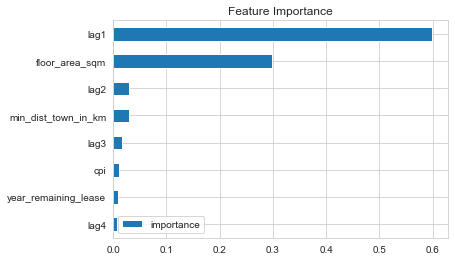

In [36]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\4201989909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


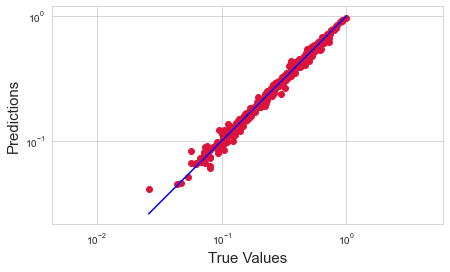

Mean Squared Error: 0.000315
Root Mean Squared Error: 0.017749
Mean absolute error: 0.012350
R2 score: 0.992094


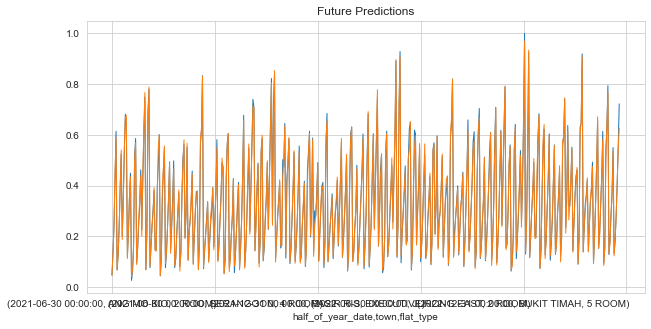

In [37]:
test['prediction'] = reg.predict(X_test)

mse = mean_squared_error(test['resale_price'], test['prediction'])
rmse = np.sqrt(mse)
mae_value = mean_absolute_error(test['resale_price'], test['prediction'])
r2 = r2_score(test['resale_price'], test['prediction'])

plt.figure(figsize=(7,4))
plt.scatter(test['resale_price'], test['prediction'], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(test['resale_price']))
p2 = min(min(y_pred), min(test['resale_price']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

print("Mean Squared Error: {:.6f}".format(mse))
print("Root Mean Squared Error: {:.6f}".format(rmse))
print("Mean absolute error: {:.6f}".format(mae_value) )
print("R2 score: {:.6f}".format(r2))

# Plot the predicted values with the actual values for the testing set
# plt.figure(figsize=(10, 6))
# print(df_xgb_grpby.index.get_level_values(0).unique())
# plt.plot(test.index.get_level_values(0), test['resale_price'], label='Actual')
# plt.plot(test.index.get_level_values(0), test['prediction'], label='Predicted')
# plt.legend()
# plt.show()
# print('Root Mean Squared Error:', rmse)
# print('Mean Absolute Error:', mae)
# print('Coefficient of Determination (R^2):', r2)

test['resale_price'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
test['prediction'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()




In [38]:
from datetime import datetime
# Create a copy of last used date
X_future = df_xgb_grpby_COPY.copy()
# have first prediction

X_future["half_of_year_date"] = X_future.index.get_level_values(0)
X_future["town"] = X_future.index.get_level_values(1)
X_future["flat_type"] = X_future.index.get_level_values(2)
X_future.reset_index(drop=True, inplace=True)

last_date_avail = X_future.half_of_year_date.max()

X_future_blank_1 = X_future[X_future['half_of_year_date'] == last_date_avail]
X_future_blank_1 = X_future_blank_1.groupby([X_future_blank_1.half_of_year_date,X_future_blank_1.town, X_future_blank_1.flat_type]).median()[['resale_price','cpi','floor_area_sqm','min_dist_town_in_km','year_remaining_lease','lag1','lag2','lag3','lag4']]

future_dates_to_predict = ['2023-06-30','2023-12-31','2024-06-30','2024-12-31']
#future_dates_to_predict = ['2023-06-30']
X_future_df = pd.DataFrame()

for date_str in future_dates_to_predict:
    X_future_blank_1.reset_index(drop=False, inplace=True)
    X_future_blank_1["half_of_year_date"] = datetime.strptime(date_str, '%Y-%m-%d')
    X_future_blank_1['lag4'] = np.nan
    X_future_blank_1['lag3'] = np.nan
    X_future_blank_1['lag2'] = np.nan
    X_future_blank_1['lag1'] = np.nan

    
    X_future_blank_1['cpi'] = X_future_blank_1['cpi'] * 1.025**((datetime.strptime(date_str, '%Y-%m-%d').year - 2022)) #Average 2.5% cpi rise per year


    new_val_scaled = ((datetime.strptime(date_str, '%Y-%m-%d').year - 2022) - min_val) / (max_val - min_val)
    X_future_blank_1['year_remaining_lease'] = X_future_blank_1['year_remaining_lease'] - new_val_scaled[4]

    
    X_future_blank_1 = X_future_blank_1.groupby([X_future_blank_1.half_of_year_date,X_future_blank_1.town, X_future_blank_1.flat_type]).median()[['resale_price','cpi','floor_area_sqm','min_dist_town_in_km','year_remaining_lease','lag1','lag2','lag3','lag4']]
    X_future_blank_1.sort_index(inplace=True)
    X_future_blank_1 = X_future_blank_1.drop('resale_price', axis=1)
    # display(X_future_blank_1)
    X_future_blank_1['resale_price'] = reg.predict(X_future_blank_1)
    X_future_df = pd.concat([X_future_df, X_future_blank_1], axis=0)
    temp = X_future_df
    temp = temp.reset_index()
    temp = temp[temp['town']=="WOODLANDS"]
    temp = temp[temp['flat_type']=="4 ROOM"]
    display(temp)
    
X_future_df.sort_index(inplace=True)
X_future_df = pd.concat([df_xgb_grpby_COPY.copy(), X_future_df], axis=0)
X_future_df = add_lags(X_future_df)

# display(X_future_df)
X_future_df = X_future_df[X_future_df.index.get_level_values(0) > last_date_avail]

# temp
# temp = X_future_df
# temp = temp.reset_index()
# temp = temp[temp['town']=="WOODLANDS"]
# temp = temp[temp['flat_type']=="4 ROOM"]
# display(temp)


,half_of_year_date,town,flat_type,cpi,floor_area_sqm,min_dist_town_in_km,year_remaining_lease,lag1,lag2,lag3,lag4,resale_price
116,2023-06-30,WOODLANDS,4 ROOM,0.955323,0.442857,0.928198,1.442308,NaN,NaN,NaN,NaN,0.336661


,half_of_year_date,town,flat_type,cpi,floor_area_sqm,min_dist_town_in_km,year_remaining_lease,lag1,lag2,lag3,lag4,resale_price
116,2023-06-30,WOODLANDS,4 ROOM,0.955323,0.442857,0.928198,1.442308,NaN,NaN,NaN,NaN,0.336661
241,2023-12-31,WOODLANDS,4 ROOM,0.979206,0.442857,0.928198,2.250000,NaN,NaN,NaN,NaN,0.336661


,half_of_year_date,town,flat_type,cpi,floor_area_sqm,min_dist_town_in_km,year_remaining_lease,lag1,lag2,lag3,lag4,resale_price
116,2023-06-30,WOODLANDS,4 ROOM,0.955323,0.442857,0.928198,1.442308,NaN,NaN,NaN,NaN,0.336661
241,2023-12-31,WOODLANDS,4 ROOM,0.979206,0.442857,0.928198,2.250000,NaN,NaN,NaN,NaN,0.336661
366,2024-06-30,WOODLANDS,4 ROOM,1.028778,0.442857,0.928198,3.038462,NaN,NaN,NaN,NaN,0.336661


,half_of_year_date,town,flat_type,cpi,floor_area_sqm,min_dist_town_in_km,year_remaining_lease,lag1,lag2,lag3,lag4,resale_price
116,2023-06-30,WOODLANDS,4 ROOM,0.955323,0.442857,0.928198,1.442308,NaN,NaN,NaN,NaN,0.336661
241,2023-12-31,WOODLANDS,4 ROOM,0.979206,0.442857,0.928198,2.250000,NaN,NaN,NaN,NaN,0.336661
366,2024-06-30,WOODLANDS,4 ROOM,1.028778,0.442857,0.928198,3.038462,NaN,NaN,NaN,NaN,0.336661
491,2024-12-31,WOODLANDS,4 ROOM,1.080860,0.442857,0.928198,3.826923,NaN,NaN,NaN,NaN,0.336661


C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\3258545259.py:26: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  mydf['lag1'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))
C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\3258545259.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  mydf['lag2'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))
C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\3258545259.py:34: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  mydf['lag3'] = mydf['key'].map(lambda x: target_dict.get(x, pd.np.nan))
C:\Users\JoeBaarath\AppData\Local\Temp\ipykernel_25088\3258545259.py:38: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in

['2023-06-30', '2023-12-31', '2024-06-30', '2024-12-31']

,half_of_year_date,town,flat_type,cpi,floor_area_sqm,min_dist_town_in_km,year_remaining_lease,lag1,lag2,lag3,lag4,prediction
116,2021-06-30,WOODLANDS,4 ROOM,0.201685,0.457143,0.933123,0.615385,0.170404,0.156951,0.150673,0.143498,0.205540
236,2021-12-31,WOODLANDS,4 ROOM,0.315490,0.478571,0.934651,0.615385,0.203587,0.170404,0.156951,0.150673,0.234296
360,2022-06-30,WOODLANDS,4 ROOM,0.627689,0.485714,0.934943,0.596154,0.233184,0.203587,0.170404,0.156951,0.265433
485,2022-12-31,WOODLANDS,4 ROOM,0.932022,0.442857,0.928198,0.634615,0.255605,0.233184,0.203587,0.170404,0.286333
610,2023-06-30,WOODLANDS,4 ROOM,0.955323,0.442857,0.928198,1.442308,0.281614,0.255605,0.233184,0.203587,0.314089
735,2023-12-31,WOODLANDS,4 ROOM,0.979206,0.442857,0.928198,2.250000,0.336661,0.281614,0.255605,0.233184,0.349556
860,2024-06-30,WOODLANDS,4 ROOM,1.028778,0.442857,0.928198,3.038462,0.336661,0.336661,0.281614,0.255605,0.355098
985,2024-12-31,WOODLANDS,4 ROOM,1.080860,0.442857,0.928198,3.826923,0.336661,0.336661,0.336661,0.281614,0.355098


Resale Price for WOODLANDS 4 ROOM


,prediction
half_of_year_date,
2021-06-30,394177.001864
2021-12-31,426239.667833
2022-06-30,460957.344770
2022-12-31,484261.488467
2023-06-30,515209.168792
2023-12-31,554755.370915
2024-06-30,560934.014320
2024-12-31,560934.014320


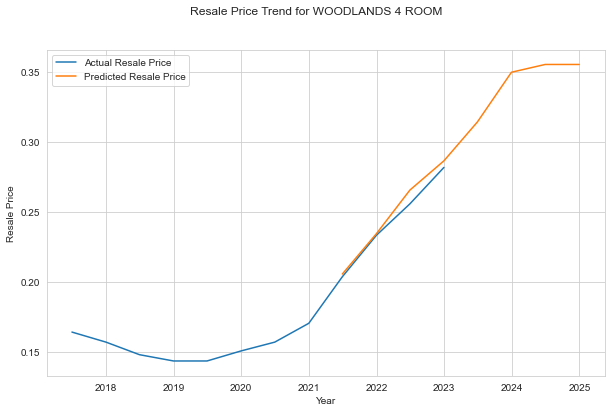

Mean absolute error: 0.004402579133286
Mean Squared Error: 0.000030972426303
Root Mean Squared Error: 0.005565287620860
R2 score: 0.962442628929114


In [39]:
town="WOODLANDS"
flat_type= "4 ROOM"
X_future_df_plot = X_future_df.copy()


X_future_df_plot_pred=X_future_df_plot
X_future_df_plot_pred = pd.concat([X_future_df_plot_pred, test.copy()])

X_future_df_plot_pred.drop("resale_price",axis=1,inplace=True)
X_future_df_plot_pred.drop("prediction",axis=1,inplace=True)
X_future_df_plot_pred.sort_index(inplace=True)

display(future_dates_to_predict)

X_future_df_plot_pred['prediction'] = reg.predict(X_future_df_plot_pred)

temp = X_future_df_plot_pred.reset_index()
temp = temp[temp['town'] == town]
temp = temp[temp["flat_type"]==flat_type]
display(temp)


X_future_df_plot = pd.concat([train.copy(), validate.copy()])
X_future_df_plot['prediction'] = np.NaN
X_future_df_plot = pd.concat([X_future_df_plot, X_future_df_plot_pred])

X_future_df_plot.reset_index(inplace=True)
X_future_df_plot = X_future_df_plot.set_index('half_of_year_date')
X_future_df_plot.index = pd.to_datetime(X_future_df_plot.index)
X_future_df_plot.sort_index(inplace=True)


X_future_df_plot = X_future_df_plot[X_future_df_plot['town'] == town]
X_future_df_plot = X_future_df_plot[X_future_df_plot["flat_type"]==flat_type]
X_future_df_plot = X_future_df_plot.loc[:, ['resale_price','prediction']]
X_future_df_plot_COPY =X_future_df_plot.copy()
X_future_df_plot_pred = X_future_df_plot.dropna(subset=['prediction'])
X_future_df_plot = X_future_df_plot.dropna(subset=['resale_price'])

print("Resale Price for WOODLANDS 4 ROOM")
pred_res = (X_future_df_plot_pred['prediction']).to_frame()
#scaler
pred_res['prediction'] = pred_res['prediction'].apply(lambda x: (x*(max_val - min_val) + min_val)[0] )
display(pred_res)

fig, axs = plt.subplots(figsize=(10, 6))

# plot the first DataFrame on the first subplot
axs.plot(X_future_df_plot.index, X_future_df_plot['resale_price'], label='Actual Resale Price')

# plot the second DataFrame on the second subplot
axs.plot(X_future_df_plot_pred.index, X_future_df_plot_pred['prediction'], label='Predicted Resale Price')


fig.suptitle('Resale Price Trend for WOODLANDS 4 ROOM')
axs.set_xlabel('Year')
axs.set_ylabel('Resale Price')

plt.legend()
plt.show()

X_future_df_plot_metrics = X_future_df_plot_COPY.copy()
X_future_df_plot_metrics = X_future_df_plot_metrics.groupby('half_of_year_date').agg({'resale_price': 'sum', 'prediction': 'sum'}).reset_index()
X_future_df_plot_metrics = X_future_df_plot_metrics.replace(0.0, np.nan)
X_future_df_plot_metrics.dropna(axis=0, how='any', inplace=True)

mae = mean_absolute_error(X_future_df_plot_metrics['resale_price'], X_future_df_plot_metrics['prediction'])
mse = mean_squared_error(X_future_df_plot_metrics['resale_price'], X_future_df_plot_metrics['prediction'])
rmse = np.sqrt(mse)
r2 = r2_score(X_future_df_plot_metrics['resale_price'], X_future_df_plot_metrics['prediction'])

print("Mean absolute error: {:.15f}".format(mae) )
print("Mean Squared Error: {:.15f}".format(mse))
print("Root Mean Squared Error: {:.15f}".format(rmse))
print("R2 score: {:.15f}".format(r2))

In [40]:
########## END OF XGBOOST #########